<a href="https://colab.research.google.com/github/aolivieri/colon/blob/master/colon_colonoscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

#tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available()

import os
os.environ['CUDA_VISIBLE_DEVICES']='0' 

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)


#from tensorflow.python.client import device_lib 
#device_lib.list_local_devices()

2.4.0


In [3]:
# Importing the libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np

#import matplotlib.pyplot as plt
from itertools import cycle

In [4]:
import tensorflow.keras.backend as K
K.clear_session()

In [7]:
# Part 1 - Data Preprocessing

# Generating images for the Training set
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

# Generating images for the Test set
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Creating the Training set
training_set = train_datagen.flow_from_directory('./Kvasir/train', 
                                                 target_size = (224, 224),
                                                 subset='training')

# Creating the Validation set
validation_set = train_datagen.flow_from_directory('./Kvasir/train',
                                                   target_size = (224, 224),
                                                   subset='validation')

# Creating the Test set
test_set = test_datagen.flow_from_directory('./Kvasir/test',
                                             target_size = (224, 224))

Found 5920 images belonging to 8 classes.
Found 1480 images belonging to 8 classes.
Found 600 images belonging to 8 classes.


In [31]:
a, b = training_set.next()
a.shape, b.shape

((32, 224, 224, 3), (32, 8))

In [32]:
from PIL import Image
import numpy as np

[0. 0. 0. 0. 0. 0. 1. 0.]


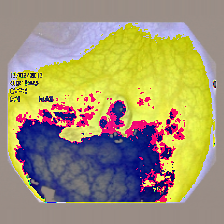

In [33]:
print(b[0])
Image.fromarray(np.uint8(a[0]))

[1. 0. 0. 0. 0. 0. 0. 0.]


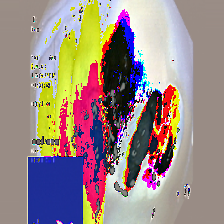

In [34]:
print(b[2])
Image.fromarray(np.uint8(a[2]))

In [35]:
from collections import Counter
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [5]:
# Transfer Learning

from tensorflow.keras.models import *

pretrained_nn = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Freeze all layers
for l in pretrained_nn.layers:
  l.trainable = False

global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(pretrained_nn.output)
fc1 = tf.keras.layers.Dense(512, activation='relu')(global_avg_pool)
fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)
output = tf.keras.layers.Dense(8, activation='softmax')(fc2)

model = Model(pretrained_nn.input, output)

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [38]:
# Training
from keras import callbacks
hist = model.fit(training_set,
                  steps_per_epoch = training_set.__len__(),
                  epochs = 50,
                  validation_data = validation_set,
                  validation_steps = validation_set.__len__(),
                  callbacks=[callbacks.ModelCheckpoint('cp-model.h5', save_best_only=True)])

Epoch 1/50
185/185 [==============================] - 119s 635ms/step - loss: 1.1683 - accuracy: 0.5899 - val_loss: 0.4815 - val_accuracy: 0.8074
Epoch 2/50
185/185 [==============================] - 111s 601ms/step - loss: 0.3923 - accuracy: 0.8533 - val_loss: 0.3952 - val_accuracy: 0.8473
Epoch 3/50
185/185 [==============================] - 111s 599ms/step - loss: 0.3301 - accuracy: 0.8733 - val_loss: 0.3974 - val_accuracy: 0.8405
Epoch 4/50
185/185 [==============================] - 110s 597ms/step - loss: 0.3120 - accuracy: 0.8707 - val_loss: 0.3653 - val_accuracy: 0.8459
Epoch 5/50
185/185 [==============================] - 111s 601ms/step - loss: 0.2919 - accuracy: 0.8841 - val_loss: 0.3660 - val_accuracy: 0.8412
Epoch 6/50
185/185 [==============================] - 112s 605ms/step - loss: 0.2774 - accuracy: 0.8900 - val_loss: 0.3454 - val_accuracy: 0.8601
Epoch 7/50
185/185 [==============================] - 111s 603ms/step - loss: 0.2653 - accuracy: 0.8933 - val_loss: 0.3417 -

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [8]:
# Avalia o modelo na validação
model.load_weights('cp-model.h5')
score = model.evaluate(validation_set,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

47/47 [==============================] - 28s 497ms/step - loss: 0.3033 - accuracy: 0.8732
Valid loss: 0.32599756121635437
Valid acc: 0.8608108162879944


In [9]:
generator = test_set

batch_index = 0
data_list = []
while batch_index <= generator.batch_index:
    _, label = generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)

preds = model.predict(generator)

cm = confusion_matrix(gt, np.argmax(preds, axis=1))
print("Matriz de confusão")
print(cm)

# Matriz de confusão normalizada
num_classes = 8
cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cmn) / num_classes
print("\n\nMatriz de confusão balanceada")
print(cmn)
print("\n\nAcurácia balanceada:", balanced_acc)

Matriz de confusão
[[61 12  0  0  0  0  2  0]
 [ 7 68  0  0  0  0  0  0]
 [ 0  0 54  0  0 21  0  0]
 [ 0  0  0 75  0  0  0  0]
 [ 0  0  0  0 74  0  1  0]
 [ 0  0  8  0  0 67  0  0]
 [ 0  0  0  6  0  0 62  7]
 [ 0  0  0  2  0  0  0 73]]


Matriz de confusão balanceada
[[0.81333333 0.16       0.         0.         0.         0.
  0.02666667 0.        ]
 [0.09333333 0.90666667 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.72       0.         0.         0.28
  0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.98666667 0.
  0.01333333 0.        ]
 [0.         0.         0.10666667 0.         0.         0.89333333
  0.         0.        ]
 [0.         0.         0.         0.08       0.         0.
  0.82666667 0.09333333]
 [0.         0.         0.         0.02666667 0.         0.
  0.         0.97333333]]


Acurácia balanceada: 0.8899999999999999

In [10]:
#auc = roc_auc_score(gt, preds, multi_class="ovr")
#print("auc :", auc)

# Compute ROC curve and ROC area for each class
n_classes = 8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_true = np.array([j[i] for j in data_list[:]])
    y_score = preds[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array([j for j in data_list[:]]).ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

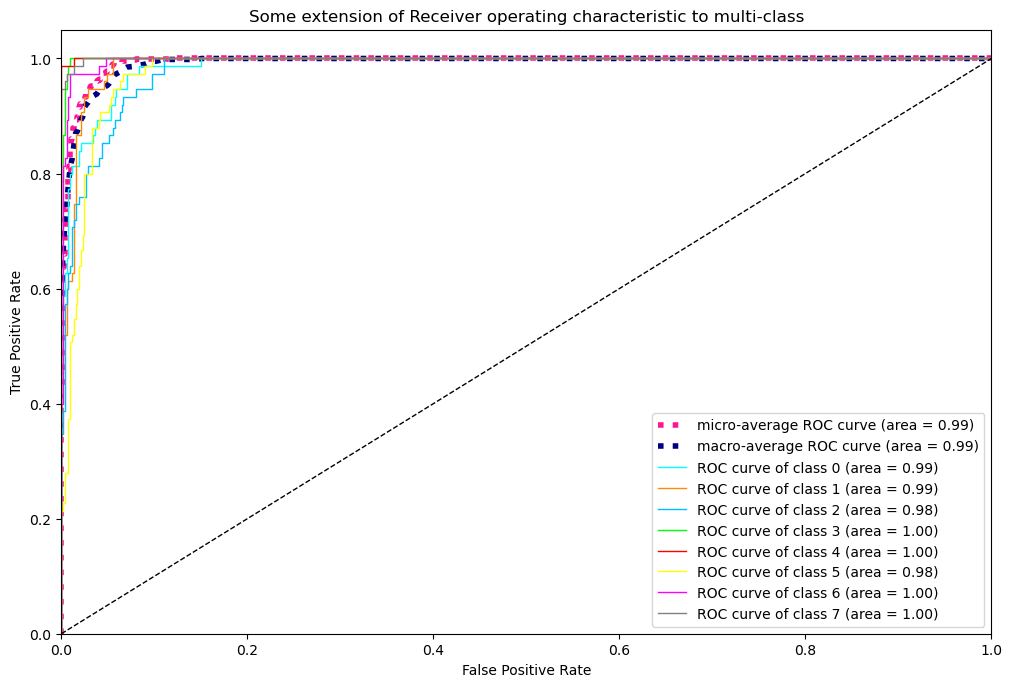

In [13]:
import matplotlib.pyplot as plt
# Plot all ROC curves
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'deepskyblue', 'lime', 'red', 'yellow', 'fuchsia', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [14]:
# summarize filter shapes
layer_num = -1
for layer in model.layers:
    # check for convolutional layer
    layer_num= layer_num + 1
    if '_conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer_num, layer.name, filters.shape)

2 conv1_conv (7, 7, 3, 64)
7 conv2_block1_1_conv (1, 1, 64, 64)
10 conv2_block1_2_conv (3, 3, 64, 64)
13 conv2_block1_0_conv (1, 1, 64, 256)
14 conv2_block1_3_conv (1, 1, 64, 256)
19 conv2_block2_1_conv (1, 1, 256, 64)
22 conv2_block2_2_conv (3, 3, 64, 64)
25 conv2_block2_3_conv (1, 1, 64, 256)
29 conv2_block3_1_conv (1, 1, 256, 64)
32 conv2_block3_2_conv (3, 3, 64, 64)
35 conv2_block3_3_conv (1, 1, 64, 256)
39 conv3_block1_1_conv (1, 1, 256, 128)
42 conv3_block1_2_conv (3, 3, 128, 128)
45 conv3_block1_0_conv (1, 1, 256, 512)
46 conv3_block1_3_conv (1, 1, 128, 512)
51 conv3_block2_1_conv (1, 1, 512, 128)
54 conv3_block2_2_conv (3, 3, 128, 128)
57 conv3_block2_3_conv (1, 1, 128, 512)
61 conv3_block3_1_conv (1, 1, 512, 128)
64 conv3_block3_2_conv (3, 3, 128, 128)
67 conv3_block3_3_conv (1, 1, 128, 512)
71 conv3_block4_1_conv (1, 1, 512, 128)
74 conv3_block4_2_conv (3, 3, 128, 128)
77 conv3_block4_3_conv (1, 1, 128, 512)
81 conv4_block1_1_conv (1, 1, 512, 256)
84 conv4_block1_2_conv (3, 3

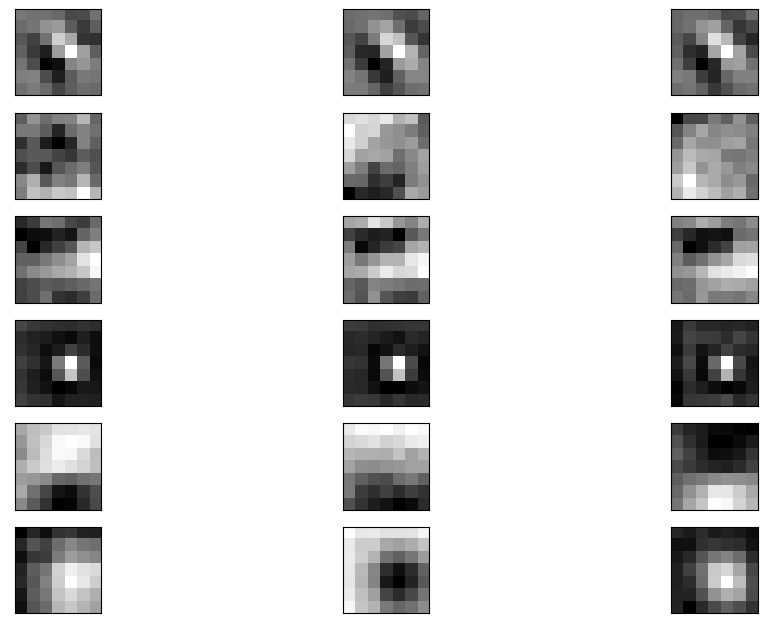

In [15]:
import matplotlib.pyplot as plt

filters, biases = model.layers[2].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)



# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [16]:
# Inspect the output of the convolutions
model2 = Model(inputs=model.inputs, outputs=model.layers[2].output)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 230, 230, 3)       0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
Total params: 9,472
Trainable params: 0
Non-trainable params: 9,472
_________________________________________________________________


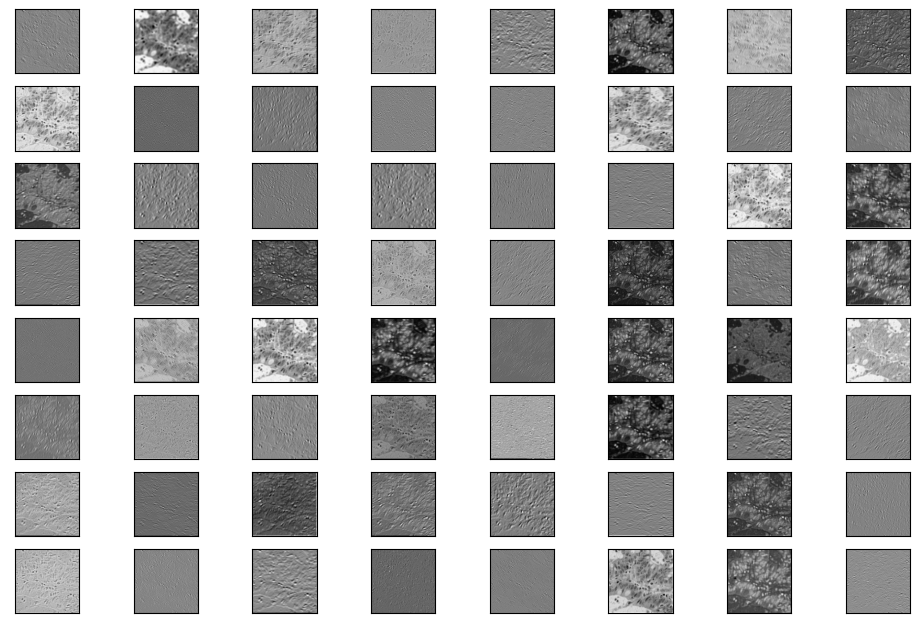

In [17]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

# load the image with the required shape
img = load_img('/home/alexandre/Documents/colon/colon_image_sets/test_set/colon_aca/colonca4501.jpeg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model2.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
# redefine model to output right after the first hidden layer
ixs = [10, 64, 96, 106, 158]
outputs = [model.layers[i+1].output for i in ixs]
model3 = Model(inputs=model.inputs, outputs=outputs)
model3.summary()

# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()